# **데이터 불러오기 및 메모리 축소**

In [ ]:
#필요한 라이브러리 불러오기 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
import lightgbm as lgb

warnings.filterwarnings('ignore')
%matplotlib inline

pd.options.display.float_format = '{:,.3f}'.format
sns.set()

In [ ]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#train 데이터 불러오기 

pubg_data = pd.read_csv("/content/drive/MyDrive/train_V2.csv")   #각자 구글 드라이브에 들어가면 바로 보이게 파일 넣으시고 경로 변경 없이 바로 데이터 불러올 수 있게 설정함 
df = pubg_data
df.info()

# 그냥 불러오면 983.9MB로 메모리가 굉장히 큰 상태 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [ ]:
%%time
#df.info()
# Memory usages in Bytes
print("Reduced Memory size: ",df.memory_usage(index=True).sum()/(1024*1024), "MB")

Reduced Memory size:  983.9022064208984 MB
CPU times: user 1.72 ms, sys: 954 µs, total: 2.67 ms
Wall time: 2.64 ms


In [ ]:
for column_name in df:
    if df[column_name].dtype=='float64':
        df[column_name] = pd.to_numeric(df[column_name], downcast= 'float')
    if df[column_name].dtype=='int64':
        df[column_name] = pd.to_numeric(df[column_name],downcast='integer')

In [ ]:
%%time
#df.info()
# Memory usages in Bytes
print("Reduced Memory size: ",df.memory_usage(index=True).sum()/(1024*1024), "MB")

# 데이터의 메모리가 상당히 많이 줄었음을 알 수 있음 

Reduced Memory size:  339.2767028808594 MB
CPU times: user 5.66 ms, sys: 139 µs, total: 5.8 ms
Wall time: 5.41 ms


# **데이터 살펴보기 및 전처리**

In [ ]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000,0,0,0,60,...,0,0.000,0,0.000,0,0,244.800,1,1466,0.444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470,0,0,0,57,...,0,0.004,0,11.040,0,0,"1,434.000",5,0,0.640
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000,0,0,0,47,...,0,0.000,0,0.000,0,0,161.800,2,0,0.775
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900,0,0,0,75,...,0,0.000,0,0.000,0,0,202.700,3,0,0.167
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000,0,0,0,45,...,0,0.000,0,0.000,0,0,49.750,2,0,0.188


In [ ]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

In [ ]:
print("Train : ", df.shape)

Train :  (4446966, 29)


In [ ]:
# col 생략 없이 출력
pd.set_option('display.max_columns', None)

In [ ]:
df.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,"4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,966.000","4,446,965.000"
mean,0.234,1.107,130.717,0.658,0.227,1.370,47.599,505.006,0.925,0.544,22.998,"1,579.506",44.505,43.008,892.010,0.165,606.116,0.003,4.509,0.024,0.008,"1,154.218",3.660,606.460,0.473
std,0.589,1.716,170.781,1.146,0.602,2.680,27.463,627.505,1.558,0.711,50.973,258.740,23.828,23.289,736.648,0.472,"1,498.344",0.073,30.502,0.167,0.093,"1,183.497",2.457,739.700,0.307
min,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,9.000,1.000,1.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,24.000,0.000,0.000,0.000,0.000,"1,367.000",28.000,27.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,155.100,2.000,0.000,0.200
50%,0.000,0.000,84.240,0.000,0.000,0.000,47.000,0.000,0.000,0.000,0.000,"1,438.000",30.000,30.000,"1,443.000",0.000,0.000,0.000,0.000,0.000,0.000,685.600,3.000,0.000,0.458
75%,0.000,2.000,186.000,1.000,0.000,2.000,71.000,"1,172.000",1.000,1.000,21.320,"1,851.000",49.000,47.000,"1,500.000",0.000,0.191,0.000,0.000,0.000,0.000,"1,976.000",5.000,"1,495.000",0.741
max,22.000,33.000,"6,616.000",53.000,64.000,80.000,101.000,"2,170.000",72.000,20.000,"1,094.000","2,237.000",100.000,100.000,"5,910.000",39.000,"40,710.000",18.000,"3,823.000",12.000,5.000,"25,780.000",236.000,"2,013.000",1.000


In [ ]:
df.isnull().sum()  #결측치는 'winPlacePerc'(승률 변수)에서 존재   

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [ ]:
df[df['winPlacePerc'].isna()==True]

# 전체 4446966 행에서 결측치 행 1행은 소수
# winPlacePerc 변수에서 결측치 값이 있는 1 행만 추출: 별 의미 없는 행
# ---> 최종적으로 이 행 제거 

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.000,0,0,0,1,0,0,0,0.000,9,solo-fpp,1,1,1574,0,0.000,0,0.000,0,0,0.000,0,0,NaN


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isnull().sum() # 모든 컬럼에 결측치가 없음을 확인 

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

In [ ]:
# train.drop(['Id'], axis=1, inplace=True) # 'Id' 변수는 플레이어의 id(처음 게임 생성했을 때 지정하는 닉네임 변수)이기에 큰 영향을 주지 않을 것 같아서 drop ----> 추후 이상치 제거에 사용할 변수기에 주석 처리 

# **매치 타입 레이블 인코딩**

In [ ]:
df['matchType'].value_counts() 

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536761
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder
df['matchType'] = df['matchType'].apply(lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) else 'etc' if ('flare' in x) or ('crash' in x) else 'squad')
encoder = LabelEncoder()
df['matchType'] = encoder.fit_transform(df['matchType'])
df['matchType'].value_counts() 

3    2400402
0    1315970
2     720712
1       9881
Name: matchType, dtype: int64

In [ ]:
print(encoder.inverse_transform([0,1,2,3])) # duo는 0으로 etc는 1로 solo는 2로 squad는 3으로 레이블인코딩 됨 

['duo' 'etc' 'solo' 'squad']


In [ ]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000,0,0,0,60,1241,0,0,0.000,1306,3,28,26,-1,0,0.000,0,0.000,0,0,244.800,1,1466,0.444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470,0,0,0,57,0,0,0,0.000,1777,3,26,25,1484,0,0.004,0,11.040,0,0,"1,434.000",5,0,0.640
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000,0,0,0,47,0,0,0,0.000,1318,0,50,47,1491,0,0.000,0,0.000,0,0,161.800,2,0,0.775
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900,0,0,0,75,0,0,0,0.000,1436,3,31,30,1408,0,0.000,0,0.000,0,0,202.700,3,0,0.167
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000,0,0,0,45,0,1,1,58.530,1424,2,97,95,1560,0,0.000,0,0.000,0,0,49.750,2,0,0.188


* 레이블 인코딩으로 듀오, 솔로, 스쿼드로 나눈뒤---> eda 시각화 부문에서 각 값들의 비율을 보여주고(파이차트) 이상치 제거하기 전에 솔로 값만 두고 무관한 칼럼 제거하는 흐름

# **솔로 데이터만 추출 후 필요 없는 컬럼 제거**

In [ ]:
display(df)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000,0,0,0,60,1241,0,0,0.000,1306,3,28,26,-1,0,0.000,0,0.000,0,0,244.800,1,1466,0.444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470,0,0,0,57,0,0,0,0.000,1777,3,26,25,1484,0,0.004,0,11.040,0,0,"1,434.000",5,0,0.640
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000,0,0,0,47,0,0,0,0.000,1318,0,50,47,1491,0,0.000,0,0.000,0,0,161.800,2,0,0.775
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900,0,0,0,75,0,0,0,0.000,1436,3,31,30,1408,0,0.000,0,0.000,0,0,202.700,3,0,0.167
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000,0,0,0,45,0,1,1,58.530,1424,2,97,95,1560,0,0.000,0,0.000,0,0,49.750,2,0,0.188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.000,0,0,0,74,1029,0,0,0.000,1873,3,29,28,-1,0,"1,292.000",0,0.000,0,0,"1,019.000",3,1507,0.179
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.150,0,0,0,69,0,0,0,0.000,1435,2,93,93,1501,0,0.000,0,0.000,0,0,81.700,6,0,0.294
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.060,0,0,0,66,0,0,0,0.000,1321,3,28,28,1500,0,0.000,0,2.184,0,0,788.700,4,0,0.481
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.400,1,1,2,11,0,2,1,98.500,1373,3,26,25,1418,2,0.000,0,0.000,0,0,"2,748.000",8,0,0.800


In [ ]:
solo_drop = ['DBNOs', 'revives', 'teamKills', 'assists', 'killPoints', 'rankPoints', 'winPoints', 'matchDuration', 'numGroups'] # 솔로 데이터만 추출할 것이기 때문에 솔로와 관련 없는 변수들, 과거 데이터 컬럼 제거
solo_model = df.drop(solo_drop, axis = 'columns') 
solo_model.head()

,Id,groupId,matchId,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,matchType,maxPlace,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0.000,0,0,60,0,0,0.000,3,28,0.000,0,0.000,0,244.800,1,0.444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,91.470,0,0,57,0,0,0.000,3,26,0.004,0,11.040,0,"1,434.000",5,0.640
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,0,68.000,0,0,47,0,0,0.000,0,50,0.000,0,0.000,0,161.800,2,0.775
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,32.900,0,0,75,0,0,0.000,3,31,0.000,0,0.000,0,202.700,3,0.167
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,100.000,0,0,45,1,1,58.530,2,97,0.000,0,0.000,0,49.750,2,0.188


In [ ]:
solo_model = solo_model[solo_model['matchType'] == 2] # matchType이 솔로인 애들만 추출 
solo_model = solo_model.drop('matchType', axis = 'columns')
solo_model.head()

,Id,groupId,matchId,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,maxPlace,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,100.000,0,0,45,1,1,58.530,97,0.000,0,0.000,0,49.750,2,0.188
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,8.538,0,0,48,0,0,0.000,96,"2,004.000",0,0.000,0,"1,089.000",6,0.737
13,b7807186e3f679,3c08e461874749,2c30ddf481c52d,1,324.200,1,5,5,4,1,49.830,97,"1,228.000",0,76.840,0,"2,050.000",6,0.875
17,92022479b92ce7,2f2c33f548c4b9,07948d723b9c0f,3,254.300,0,12,13,2,1,36.000,96,"2,367.000",0,15.290,0,"1,787.000",3,0.821
35,47143f942503e0,e17a8867a393ec,bc2faecb77e5ec,0,136.900,0,0,37,1,1,22.830,96,0.000,0,0.000,0,270.700,1,0.347


In [ ]:
df=solo_model.copy()
display(df)

,Id,groupId,matchId,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,maxPlace,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,100.000,0,0,45,1,1,58.530,97,0.000,0,0.000,0,49.750,2,0.188
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,8.538,0,0,48,0,0,0.000,96,"2,004.000",0,0.000,0,"1,089.000",6,0.737
13,b7807186e3f679,3c08e461874749,2c30ddf481c52d,1,324.200,1,5,5,4,1,49.830,97,"1,228.000",0,76.840,0,"2,050.000",6,0.875
17,92022479b92ce7,2f2c33f548c4b9,07948d723b9c0f,3,254.300,0,12,13,2,1,36.000,96,"2,367.000",0,15.290,0,"1,787.000",3,0.821
35,47143f942503e0,e17a8867a393ec,bc2faecb77e5ec,0,136.900,0,0,37,1,1,22.830,96,0.000,0,0.000,0,270.700,1,0.347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446950,d05b0c4b2ff311,8248fa2552457b,88c002b589d411,0,203.500,0,0,32,1,1,11.270,95,0.000,0,0.000,0,"1,559.000",5,0.500
4446954,894c01c8e4524f,c33e793af077f9,deb3a91c03d0f3,0,30.100,0,0,58,0,0,0.000,99,0.000,0,0.000,0,"2,146.000",6,0.531
4446959,d29bfa313ad766,ac3f1b4a56e5ad,2f3b1af94739b3,0,22.680,0,0,89,0,0,0.000,96,0.000,0,0.000,0,40.250,1,0.084
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,1,44.150,0,0,69,0,0,0.000,93,0.000,0,0.000,0,81.700,6,0.294


# **이상치 제거**

현재 train 데이터에는 정상적인 게임에서 나올 수 없는 행들이 존재 ex)  
* 이동이 없는데 kill 수가 존재  
* 한 매치에서 최대 킬 수가 해당매치 참여 인원보다 많은 경우  
* 차량 탄 거리가 0인데 roadkill이 1이상인 경우   
.   
.   
.   


**1) 이동 거리 관련**  
* totalDistance = walkDistance + rideDistance + swimDistance인 파생변수 생성

In [ ]:
# totalDistance 파생 변수 생성 
df['totalDistance'] = df['walkDistance']+df['rideDistance']+df['swimDistance']
df.head()

,Id,groupId,matchId,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,maxPlace,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,totalDistance
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,100.000,0,0,45,1,1,58.530,97,0.000,0,0.000,0,49.750,2,0.188,49.750
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,8.538,0,0,48,0,0,0.000,96,"2,004.000",0,0.000,0,"1,089.000",6,0.737,"3,093.000"
13,b7807186e3f679,3c08e461874749,2c30ddf481c52d,1,324.200,1,5,5,4,1,49.830,97,"1,228.000",0,76.840,0,"2,050.000",6,0.875,"3,354.840"
17,92022479b92ce7,2f2c33f548c4b9,07948d723b9c0f,3,254.300,0,12,13,2,1,36.000,96,"2,367.000",0,15.290,0,"1,787.000",3,0.821,"4,169.290"
35,47143f942503e0,e17a8867a393ec,bc2faecb77e5ec,0,136.900,0,0,37,1,1,22.830,96,0.000,0,0.000,0,270.700,1,0.347,270.700


In [ ]:
# totalDistance=0인데 Kills, killStreaks, longestkill,  headshot, boosts, hill, weaponsAcquired>0 인 데이터프레임
# ---> 총 거리량이 0인데 총 킬 수, 헤드샷 킬 수, 아이템 사용수, 무기 획득 수가 1이상일 수가 없음  

df.loc[(df.totalDistance==0) & ((df.kills>0) | (df.killStreaks>0) | (df.longestKill>0) | 
                                      (df.headshotKills>0) | (df.boosts>0) |(df.heals>0) | (df.weaponsAcquired>0)),]  #12293 행 

,Id,groupId,matchId,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,maxPlace,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,totalDistance
846,0df7c355497d77,325464bcf4c846,f3a64f99badeca,0,0.000,0,0,5,0,0,0.000,19,0.000,0,0.000,0,0.000,6,0.000,0.000
1357,72f70c6c074ca9,da042db555b932,f3c5fa51aacb95,0,722.800,0,0,5,0,0,0.000,18,0.000,0,0.000,0,0.000,15,0.000,0.000
1433,0a5036716cd6e0,65d3de7c9396c4,75cbdf89be0139,0,85.600,0,0,90,0,0,0.000,90,0.000,0,0.000,0,0.000,1,0.000,0.000
1814,269108abb1ba4e,28d3205dd35436,61ec8e0f6bd01d,0,0.000,0,0,94,0,0,0.000,95,0.000,0,0.000,0,0.000,1,0.011,0.000
2640,62f59fc192169d,9151ba6ff83a5a,827e75036742f3,0,291.500,0,0,7,0,0,0.000,17,0.000,0,0.000,0,0.000,2,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446318,13ca7294094cfb,0e120a8d2f6105,07baf6b1ba3de9,0,0.000,0,0,1,0,0,0.000,18,0.000,0,0.000,0,0.000,21,0.000,0.000
4446464,672a8673146c3e,910ef021cfa4ee,7d66e01d3d9cd5,0,0.000,0,0,91,0,0,0.000,95,0.000,0,0.000,0,0.000,1,0.053,0.000
4446682,b444f8c7af62b5,4e5b8eefdd669e,54277ef2ed69b7,0,41.950,0,0,48,1,1,43.380,54,0.000,0,0.000,0,0.000,4,0.943,0.000
4446786,12c053c0567dca,9db52b9e2d4f8c,fe0c3ccbea8181,0,0.000,0,0,84,0,0,0.000,84,0.000,0,0.000,0,0.000,1,0.000,0.000


In [ ]:
720712-12293

708419

In [ ]:
df = df.drop(df[df.totalDistance==0][df.kills>0].index) # 총 거리량이 0인데 킬 수가 0 이상인 행 제거 
df = df.drop(df[df.totalDistance==0][df.killStreaks>0].index) # 총 거리량이 0인데 단기간 최대 킬 수가 0 이상인 행 제거 
df = df.drop(df[df.totalDistance==0][df.longestKill>0].index) # 총 거리량이 0인데 킬과 킬 사이 최장거리가 0 이상인 행 제거
df = df.drop(df[df.totalDistance==0][df.headshotKills>0].index) # 총 거리량이 0인데 헤드샷 킬 수가 0 이상인 행 제거 
df = df.drop(df[df.totalDistance==0][df.boosts>0].index) # 총 거리량이 0인데 부스트 아이템 사용 횟수가 0 이상인 행 제거 
df = df.drop(df[df.totalDistance==0][df.heals>0].index) # 총 거리량이 0인데 힐링 아이템 사용 횟수가 0 이상인 행 제거 
df = df.drop(df[df.totalDistance==0][df.weaponsAcquired>0].index) # 총 거리량이 0인데 얻은 무기의 수가 0 이상인 행 제거 

In [ ]:
# 자동차를 탄 거리량이 0인데 자동차킬이 1 이상인 경우----> 로드킬은 자동차를 타고 이동할 때만 생기는 건데 차량 거리량이 0인데 로드킬이 1이상은 이상치 
df.loc[(df.rideDistance==0) & (df.roadKills>0), ] #0행  

,Id,groupId,matchId,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,maxPlace,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,totalDistance


In [ ]:
# rideDistance==0 & roadKills>0 인 값을 가진 행들 제거 
df=df.drop(index=df[(df['rideDistance']==0) & (df['roadKills']>0)  ].index)

**2) 매치 관련**

In [ ]:
df['num']=df.groupby('matchId')['kills'].transform('sum') #matchId 기준으로 그룹을 묶어서 킬 횟수를 세는 'num' 변수 생성 

In [ ]:
df.head()

,Id,groupId,matchId,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,maxPlace,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,totalDistance,num
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,100.000,0,0,45,1,1,58.530,97,0.000,0,0.000,0,49.750,2,0.188,49.750,91.000
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,8.538,0,0,48,0,0,0.000,96,"2,004.000",0,0.000,0,"1,089.000",6,0.737,"3,093.000",86.000
13,b7807186e3f679,3c08e461874749,2c30ddf481c52d,1,324.200,1,5,5,4,1,49.830,97,"1,228.000",0,76.840,0,"2,050.000",6,0.875,"3,354.840",88.000
17,92022479b92ce7,2f2c33f548c4b9,07948d723b9c0f,3,254.300,0,12,13,2,1,36.000,96,"2,367.000",0,15.290,0,"1,787.000",3,0.821,"4,169.290",91.000
35,47143f942503e0,e17a8867a393ec,bc2faecb77e5ec,0,136.900,0,0,37,1,1,22.830,96,0.000,0,0.000,0,270.700,1,0.347,270.700,94.000


In [ ]:
# matchid로 groupby 했을 때, kills가 모두 0인 경우----> 한 매치당 전체 킬 수가 0일 수가 없음 
df.loc[(df.num==0), ] #1075행 

,Id,groupId,matchId,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,maxPlace,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,totalDistance,num
3962,b553c49b7cea2a,f603d46c0cf8e6,c62a9311ca6624,0,0.000,0,0,17,0,0,0.000,17,0.000,0,0.000,0,0.000,0,0.000,0.000,0.000
6771,f7acd8915c42be,7ce7d87b8db94a,e0802c8084d50d,0,0.000,0,0,17,0,0,0.000,19,0.000,0,0.000,0,0.000,0,0.000,0.000,0.000
7105,b04b8dd27fda90,00af6bab6a98cc,48beae05cf8f80,0,0.000,0,0,19,0,0,0.000,19,0.000,0,0.000,0,0.000,0,0.000,0.000,0.000
11609,cf20461d1207da,65c0fd07b89577,d1fdec9e4632dc,0,0.000,0,0,2,0,0,0.000,16,0.000,0,0.000,0,130.300,4,0.000,130.300,0.000
12628,09886f67d5a30d,5b2405c02106d6,8ca30ed6e8926d,0,0.000,0,0,11,0,0,0.000,19,0.000,0,0.000,0,0.000,0,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4422789,5125476e21721a,e4bbbbd7af29dc,d1c663de6e23bf,1,0.000,0,2,1,0,0,0.000,16,"8,682.000",0,0.000,0,806.300,2,1.000,"9,488.300",0.000
4422909,5e030e2f841f25,2d03c8cef40074,ad64e518208d26,0,0.000,0,0,18,0,0,0.000,18,0.000,0,0.000,0,0.000,0,0.000,0.000,0.000
4427944,edee71fedeec1d,d029d09dbba6fe,cf0cb51c829eb5,0,0.000,0,0,18,0,0,0.000,18,0.000,0,0.000,0,0.000,0,0.000,0.000,0.000
4430451,69f2d577afb916,1ca82eb3229fe3,8b1af8b54b0edb,0,0.000,0,0,2,0,0,0.000,18,0.000,0,0.000,0,0.000,0,1.000,0.000,0.000


In [ ]:
df=df.drop(index=df[(df['num']==0) ].index) # 한 매치당 전체 킬 수가 0인 행 제거 

In [ ]:
df.drop(['num'], axis=1, inplace=True) # 위에서 생성한 'num' 변수 필요 없으니 제거 

In [ ]:
# 매치에서의 킬 횟수 순위가 100 초과인 경우 ---> 한 매치당 최대 100인이기 때문에 순위가 100 초과일 수가 없음
df.loc[(df.killPlace)>100,] #0행 

,Id,groupId,matchId,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,maxPlace,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,totalDistance


In [ ]:
# killPlace가 match 참여 인원 수보다 큰 경우 제거
df=df.drop(index=df[df['killPlace']>100].index) 

In [ ]:
# matchId 별 player 수
df['cnt_per_matchid'] = df.groupby('matchId').Id.transform('count')

In [ ]:
#killplace가 match 참여 인원 수보다 큰 경우 ----> 킬 순위가 매치 참여 인원 수보다 클 수가 없음 
df.loc[(df.cnt_per_matchid)<(df.killPlace),] #4220행 

,Id,groupId,matchId,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,maxPlace,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,totalDistance,cnt_per_matchid
109,de93ba20446980,29276739992710,7456e2eaa324a2,0,19.350,0,0,96,0,0,0.000,96,0.000,0,0.000,0,20.340,1,0.000,20.340,95
994,b890be433d01b4,9ad75b9e378d08,df5f39b08f895f,0,0.000,0,0,96,0,0,0.000,96,0.000,0,0.000,0,24.560,0,0.000,24.560,95
1475,1296e1acf0eea2,fd2b3948654213,8cc67fbee871d4,0,0.000,0,0,96,0,0,0.000,96,0.000,0,0.000,0,0.000,0,0.000,0.000,95
2743,fe80d53633542c,3f2048b9286fc8,4f3cbb2d21c9a5,0,72.970,0,0,97,0,0,0.000,97,0.000,0,0.000,0,5.243,1,0.000,5.243,95
4758,af4042f475f30b,5dd3c6dc6142ae,b08f13b9493fa8,0,0.000,0,0,96,0,0,0.000,97,0.000,0,0.000,0,0.000,0,0.000,0.000,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4441930,db45546c2edf7e,2799c91e3c93ca,e846ffd3df3e27,0,0.000,0,0,91,0,0,0.000,92,0.000,0,0.000,0,0.000,0,0.000,0.000,88
4442256,56a33b67ce1c73,5b054bbed16d37,061aa6ad1e3588,0,0.000,0,0,98,0,0,0.000,98,0.000,0,0.000,0,6.598,1,0.000,6.598,97
4442331,8ba32f65600c4f,80222689dfca6c,a1f9488a2148b8,0,0.000,0,0,94,0,0,0.000,94,0.000,0,0.000,0,1.486,2,0.000,1.486,93
4442636,42c90219230285,fb0f25c91aa1e6,3884eb78a36ea4,0,0.000,0,0,96,0,0,0.000,96,0.000,0,0.000,0,5.202,1,0.000,5.202,94


In [ ]:
# killPlace가 match 참여 인원 수보다 큰 경우 제거
df=df.drop(index=df[df['cnt_per_matchid'] < df['killPlace']].index) 

**3) kill 관련**

In [ ]:
# 데미지 양이 없는데 킬 수가 있는 경우----> 킬을 해야 해당 킬에 따라서 데미지가 생기기 때문에 딜이 없다면 킬 수가 생길 수가 없음 
df.loc[(df.damageDealt==0) & (df.kills>0)] #0행 

,Id,groupId,matchId,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,maxPlace,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,totalDistance,cnt_per_matchid


In [ ]:
# danageDealt==0 & kills>0인 값을 가진 행들 제거 
df=df.drop(index=df[ (df['damageDealt']==0) & (df['kills']>0)  ].index)

In [ ]:
# 한 매치에서 최대 킬 수가 해당 매치의 참여 인원 수 보다 많은 경우 -----> ex) 매치의 참여 인원 수가 95명인데 나의 최대 킬 수가 96일 수가 없음

# 같은 게임에 참여한 사람 수 컬럼 수 만듦
df['num']=df.groupby('matchId')['Id'].transform('count')
# 한 게임에서 최대 킬수 컬럼
df['max']=df.groupby('matchId')['kills'].transform('max')

df.loc[df['max']>df['num']] #707행 

,Id,groupId,matchId,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,maxPlace,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,totalDistance,cnt_per_matchid,num,max
42857,93ed29a0b51966,b4583304a6b039,e024bf51bf1799,0,"1,564.000",3,2,15,14,2,100.300,19,"1,315.000",0,0.000,0,"1,173.000",50,0.222,"2,488.000",19,19,55
42944,892d21c557f2a0,9b082f2f2a257b,13e1f74431c818,0,580.500,1,0,17,3,1,228.000,20,0.000,0,0.000,0,787.500,20,0.526,787.500,24,21,27
50279,fede4e068062fb,899307b1010c21,a9e84c456cc859,0,"1,691.000",3,7,6,19,2,48.320,13,0.000,0,0.000,0,165.300,52,0.667,165.300,13,13,39
50861,26809358eab674,994b105bcc3a60,7c785a64ec89df,0,352.200,0,2,6,2,1,96.110,6,0.000,0,0.000,0,502.400,25,0.000,502.400,7,7,12
56803,fc5c02efb64c79,5494cef4325c54,99006c081023c4,0,463.100,4,0,18,4,1,1.250,21,0.000,0,0.000,0,20.700,11,0.150,20.700,19,18,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393177,463eaa4e3c5a81,ec7fd8c239b50c,7a7755e592e9d0,0,"1,372.000",3,3,6,13,1,45.970,13,0.000,0,0.000,0,105.600,21,0.917,105.600,13,11,29
4413845,e0ff85734ac638,6ac82518a3ec70,f88d95bebc46fa,0,"1,101.000",7,0,7,11,2,63.820,9,0.000,0,0.000,0,348.600,21,0.250,348.600,9,8,21
4418629,871c3cc7a672e7,cdf486b986ac62,bf0b1ec5a38f7d,0,"1,634.000",2,0,7,14,2,52.120,20,"3,652.000",0,0.000,0,"1,026.000",34,0.684,"4,678.000",20,18,22
4420563,0a2721fcf1cdd9,1708576031cf96,fcd20a43cb81ea,0,"3,297.000",5,4,1,30,5,203.400,20,0.000,0,0.000,0,253.000,32,1.000,253.000,18,15,30


In [ ]:
# 최대 킬수가 한 게임 사람 수 보다 많을 수 없음, 행 제거
df=df.drop(index=df[(df['max']>df['num'])].index)

In [ ]:
df.drop(['num', 'max'], axis=1, inplace=True)  # 이상치 제거를 위해 생성한 num, max 컬럼 제거

In [ ]:
# 승률이 1인데 총 거리량이 0인 값과 무기 습득이 0인 행들----> 팀은 가능하지만(나는 가만히 있고 아무것도 안 해도 팀원이 잘하면 승률이 1 가능), 솔로인 경우는 무기도 없고 이동이 없다면 승률이 1일 수가 없음. 
df.loc[(df.winPlacePerc==1) & ((df.totalDistance==0)|(df.weaponsAcquired==0)), ] #0행

,Id,groupId,matchId,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,maxPlace,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,totalDistance,cnt_per_matchid


**거리 관련 상자그래프 통해서 이상치 값인 행들 제거 진행**

In [ ]:
distance = df[['rideDistance', 'swimDistance', 'walkDistance','winPlacePerc']]
corr_rank = distance.corr()["winPlacePerc"].sort_values(ascending=False)
print(corr_rank)

winPlacePerc   1.000
walkDistance   0.815
rideDistance   0.318
swimDistance   0.166
Name: winPlacePerc, dtype: float64


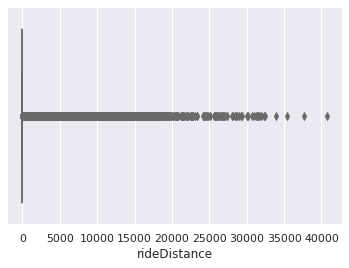

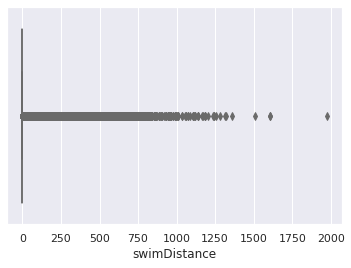

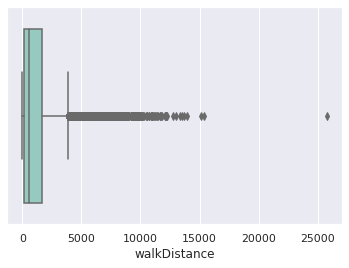

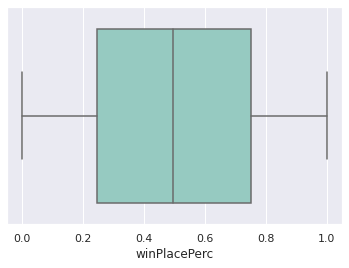

In [ ]:
for i in distance:
  sns.boxplot(x = i,  data = df,palette = "Set3")
  plt.show()

In [ ]:
df[df['rideDistance']>40000] #1행 존재

,Id,groupId,matchId,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,maxPlace,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,totalDistance,cnt_per_matchid
4099938,afe34618b04d77,c14f532b283844,732c3b752e055f,0,0.000,0,0,42,0,0,0.000,93,"40,710.000",0,0.000,0,560.100,0,0.848,"41,270.102",92


In [ ]:
df[df['swimDistance']>1750]  #1행 존재 

,Id,groupId,matchId,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,maxPlace,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,totalDistance,cnt_per_matchid
845213,3e0ae6d0e5c266,0b979aaa539ccd,9f4959a9f9c133,0,0.000,0,0,45,0,0,0.000,94,0.000,0,"1,974.000",0,18.680,0,0.850,"1,992.680",94


In [ ]:
df[df['walkDistance']>25000] #1행 존재

,Id,groupId,matchId,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,maxPlace,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,totalDistance,cnt_per_matchid
497965,3304d0c68e27f5,503757159d22dd,ce88f9c8c35bdf,0,0.000,0,0,46,0,0,0.000,95,0.008,0,381.900,0,"25,780.000",0,0.989,"26,161.908",95


In [ ]:
df=df.drop(index=df[df['rideDistance']>40000].index) 
df=df.drop(index=df[df['swimDistance']>1750].index) 
df=df.drop(index=df[df['walkDistance']>25000].index) 

In [ ]:
len(df)  
# 원본 데이터 4446966행에서 matyType이 솔로인 값들만 추출후, 정상적인 게임에서는 발생할 수 없는 이상치 행들 제거, 거리 관련(상자그래프 기준) 이상치 행들 제거 

702414

# **이상치 제거 후 시각화** (문제있음 확인 요망)

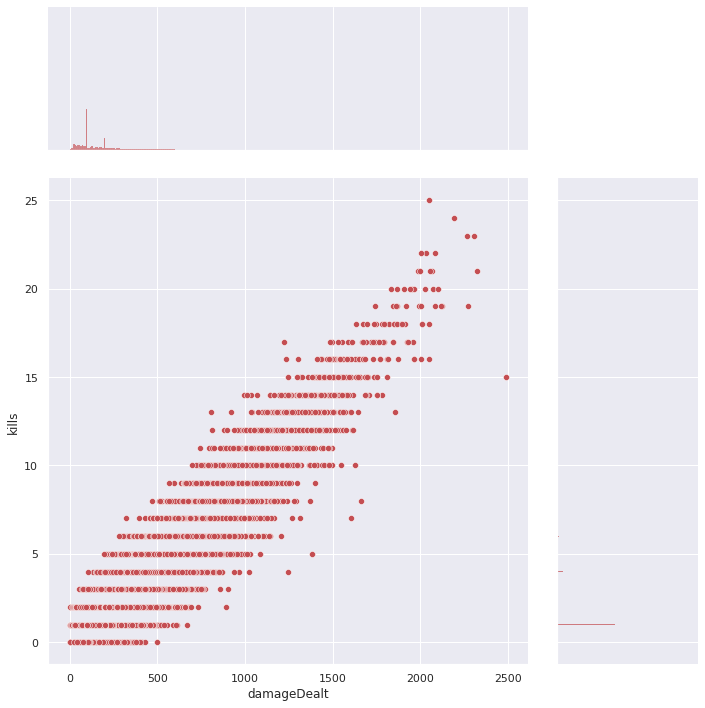

In [ ]:
# kill과 damagaDealt과의 관에서 이상치있던 부분들 

sns.jointplot(x="damageDealt", y="kills", data=df, height=10, ratio=3, color="r")  # damageDealt가 0인데 kills가 0이상일 가능성 없음---> 이상치를 제거 후 재시각화 
plt.show()

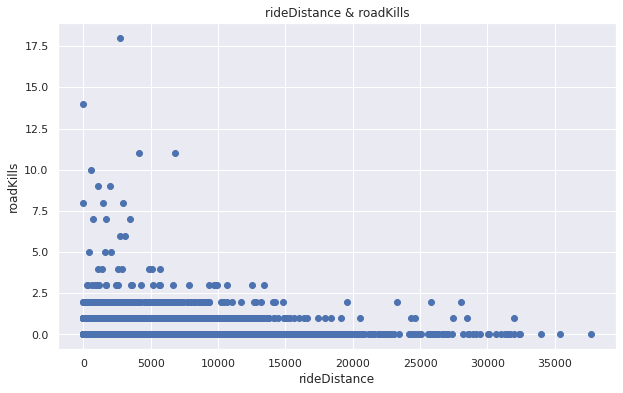

In [ ]:
# rideDistance와 roadKill과의 관계에서 이상치 제거 후 재 시각화

plt.figure(figsize=(10,6))
plt.title('rideDistance & roadKills')
# x축 라벨 설정
plt.xlabel('rideDistance')
# x축 라벨 설정
plt.ylabel('roadKills')
plt.ticklabel_format(axis ='y', useOffset = False, style = 'plain')
plt.scatter(df['rideDistance'], df['roadKills'])
plt.show()

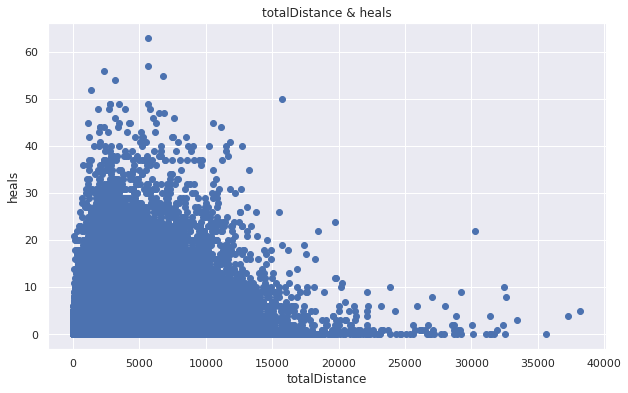

In [ ]:
# 총 거리량과 힐 수의 관계, 이상치 제거 후 재 시각화

plt.figure(figsize=(10,6))
plt.title('totalDistance & heals')
# x축 라벨 설정
plt.xlabel('totalDistance')
# x축 라벨 설정
plt.ylabel('heals')
plt.ticklabel_format(axis ='y', useOffset = False, style = 'plain')
plt.scatter(df['totalDistance'], df['heals'])
plt.show()

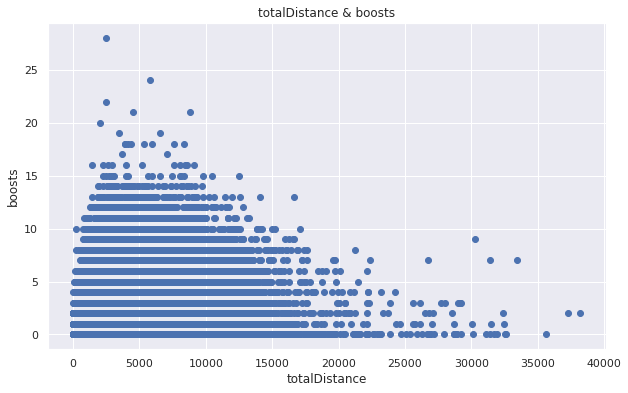

In [ ]:
# 총 거리량과 부스트 수의 관계, 이상치 제거 후 재 시각화

plt.figure(figsize=(10,6))
plt.title('totalDistance & boosts')
# x축 라벨 설정
plt.xlabel('totalDistance')
# x축 라벨 설정
plt.ylabel('boosts')
plt.ticklabel_format(axis ='y', useOffset = False, style = 'plain')
plt.scatter(df['totalDistance'], df['boosts'])
plt.show()

# **파생 변수 생성**

In [ ]:
# walk, ride, swim 중 하나만 했을 수 있어서 totalDistance 변수 생성
df['totalDistance'] = df['walkDistance'] + df['rideDistance'] + df['swimDistance']

In [ ]:
# heals + boosts 값만
df['total_heals'] = df['heals'] + df['boosts']

In [ ]:
# items = heals + boosts + weapon
df['items'] = df['heals'] + df['boosts'] +df['weaponsAcquired']

In [ ]:
# # teamwork = 아군을 보조 + 부활
# df['teamwork'] = df['assists'] + df['revives']

In [ ]:
# agg = df.groupby('groupId').size().to_frame('players_in_team')
# df = df.merge(agg, on='groupId')

In [ ]:
# kill 대비 headshot
df['headshots_over_kills'] = df['headshotKills'] / df['kills']
df['headshots_over_kills'] = df['headshots_over_kills'].fillna(0)

In [ ]:
df.loc[df['headshotKills']>df['kills']]  
#위에서 생성한 파생변수에서는 총 킬수 대비의 헤드샷 킬 수 이기 때문에 전제가 헤드샷이 킬 수 보다 크면 안되는 거기 때문에, 해당 행이 존재하는지 확인
# ----> 0행이니 위에서 생성한 파생변수 유의미함 

,Id,groupId,matchId,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,maxPlace,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,totalDistance,cnt_per_matchid,total_heals,items,headshots_over_kills


In [ ]:
# (kill횟수 순위) / (최악의 순위)
df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']

In [ ]:
# heals 대비 걸은 거리
df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
df['walkDistance_over_heals'] = df['walkDistance_over_heals'].replace(np.inf, 0)

In [ ]:
# kill 대비 걸은 거리
df['workDistance_over_kills'] = df['walkDistance'] / df['kills']
df['workDistance_over_kills'] = df['workDistance_over_kills'].fillna(0)
df['workDistance_over_kills'] = df['workDistance_over_kills'].replace(np.inf, 0)

In [ ]:
# matchId 별 player 수
df['cnt_per_matchid'] = df.groupby('matchId').Id.transform('count')

In [ ]:
# match 내 player수 대비 kill 수
df['kills_over_match_cnt']=df['kills']/df['cnt_per_matchid']

In [ ]:
display(df)

,Id,groupId,matchId,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,maxPlace,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,totalDistance,cnt_per_matchid,total_heals,items,headshots_over_kills,killPlace_over_maxPlace,walkDistance_over_heals,workDistance_over_kills,kills_over_match_cnt
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,100.000,0,0,45,1,1,58.530,97,0.000,0,0.000,0,49.750,2,0.188,49.750,97,0,2,0.000,0.464,0.000,49.750,0.010
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,8.538,0,0,48,0,0,0.000,96,"2,004.000",0,0.000,0,"1,089.000",6,0.737,"3,093.000",96,0,6,0.000,0.500,0.000,0.000,0.000
13,b7807186e3f679,3c08e461874749,2c30ddf481c52d,1,324.200,1,5,5,4,1,49.830,97,"1,228.000",0,76.840,0,"2,050.000",6,0.875,"3,354.840",97,6,12,0.250,0.052,410.000,512.500,0.041
17,92022479b92ce7,2f2c33f548c4b9,07948d723b9c0f,3,254.300,0,12,13,2,1,36.000,96,"2,367.000",0,15.290,0,"1,787.000",3,0.821,"4,169.290",96,15,18,0.000,0.135,148.917,893.500,0.021
35,47143f942503e0,e17a8867a393ec,bc2faecb77e5ec,0,136.900,0,0,37,1,1,22.830,96,0.000,0,0.000,0,270.700,1,0.347,270.700,96,0,1,0.000,0.385,0.000,270.700,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446950,d05b0c4b2ff311,8248fa2552457b,88c002b589d411,0,203.500,0,0,32,1,1,11.270,95,0.000,0,0.000,0,"1,559.000",5,0.500,"1,559.000",93,0,5,0.000,0.337,0.000,"1,559.000",0.011
4446954,894c01c8e4524f,c33e793af077f9,deb3a91c03d0f3,0,30.100,0,0,58,0,0,0.000,99,0.000,0,0.000,0,"2,146.000",6,0.531,"2,146.000",99,0,6,0.000,0.586,0.000,0.000,0.000
4446959,d29bfa313ad766,ac3f1b4a56e5ad,2f3b1af94739b3,0,22.680,0,0,89,0,0,0.000,96,0.000,0,0.000,0,40.250,1,0.084,40.250,96,0,1,0.000,0.927,0.000,0.000,0.000
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,1,44.150,0,0,69,0,0,0.000,93,0.000,0,0.000,0,81.700,6,0.294,81.700,93,1,7,0.000,0.742,0.000,0.000,0.000


In [ ]:
id_drop = ['Id', 'groupId'] #id 관련 컬럼 변수들 제거 , ---> matchid 는 보류 
df = df.drop(id_drop, axis = 'columns') 
df.head()

,matchId,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,maxPlace,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,totalDistance,cnt_per_matchid,total_heals,items,headshots_over_kills,killPlace_over_maxPlace,walkDistance_over_heals,workDistance_over_kills,kills_over_match_cnt
4,6dc8ff871e21e6,0,100.000,0,0,45,1,1,58.530,97,0.000,0,0.000,0,49.750,2,0.188,49.750,97,0,2,0.000,0.464,0.000,49.750,0.010
7,292611730ca862,0,8.538,0,0,48,0,0,0.000,96,"2,004.000",0,0.000,0,"1,089.000",6,0.737,"3,093.000",96,0,6,0.000,0.500,0.000,0.000,0.000
13,2c30ddf481c52d,1,324.200,1,5,5,4,1,49.830,97,"1,228.000",0,76.840,0,"2,050.000",6,0.875,"3,354.840",97,6,12,0.250,0.052,410.000,512.500,0.041
17,07948d723b9c0f,3,254.300,0,12,13,2,1,36.000,96,"2,367.000",0,15.290,0,"1,787.000",3,0.821,"4,169.290",96,15,18,0.000,0.135,148.917,893.500,0.021
35,bc2faecb77e5ec,0,136.900,0,0,37,1,1,22.830,96,0.000,0,0.000,0,270.700,1,0.347,270.700,96,0,1,0.000,0.385,0.000,270.700,0.010


In [ ]:
df.info()

# 최종적으로 702414행과 26컬럼(파생변수 포함)로 됨 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 702414 entries, 4 to 4446965
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   matchId                  702414 non-null  object 
 1   boosts                   702414 non-null  int8   
 2   damageDealt              702414 non-null  float32
 3   headshotKills            702414 non-null  int8   
 4   heals                    702414 non-null  int8   
 5   killPlace                702414 non-null  int8   
 6   kills                    702414 non-null  int8   
 7   killStreaks              702414 non-null  int8   
 8   longestKill              702414 non-null  float32
 9   maxPlace                 702414 non-null  int8   
 10  rideDistance             702414 non-null  float32
 11  roadKills                702414 non-null  int8   
 12  swimDistance             702414 non-null  float32
 13  vehicleDestroys          702414 non-null  int8   
 14  wal

In [75]:
df

,matchId,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,maxPlace,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,totalDistance,cnt_per_matchid,total_heals,items,headshots_over_kills,killPlace_over_maxPlace,walkDistance_over_heals,workDistance_over_kills,kills_over_match_cnt
4,6dc8ff871e21e6,0,100.000,0,0,45,1,1,58.530,97,0.000,0,0.000,0,49.750,2,0.188,49.750,97,0,2,0.000,0.464,0.000,49.750,0.010
7,292611730ca862,0,8.538,0,0,48,0,0,0.000,96,"2,004.000",0,0.000,0,"1,089.000",6,0.737,"3,093.000",96,0,6,0.000,0.500,0.000,0.000,0.000
13,2c30ddf481c52d,1,324.200,1,5,5,4,1,49.830,97,"1,228.000",0,76.840,0,"2,050.000",6,0.875,"3,354.840",97,6,12,0.250,0.052,410.000,512.500,0.041
17,07948d723b9c0f,3,254.300,0,12,13,2,1,36.000,96,"2,367.000",0,15.290,0,"1,787.000",3,0.821,"4,169.290",96,15,18,0.000,0.135,148.917,893.500,0.021
35,bc2faecb77e5ec,0,136.900,0,0,37,1,1,22.830,96,0.000,0,0.000,0,270.700,1,0.347,270.700,96,0,1,0.000,0.385,0.000,270.700,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446950,88c002b589d411,0,203.500,0,0,32,1,1,11.270,95,0.000,0,0.000,0,"1,559.000",5,0.500,"1,559.000",93,0,5,0.000,0.337,0.000,"1,559.000",0.011
4446954,deb3a91c03d0f3,0,30.100,0,0,58,0,0,0.000,99,0.000,0,0.000,0,"2,146.000",6,0.531,"2,146.000",99,0,6,0.000,0.586,0.000,0.000,0.000
4446959,2f3b1af94739b3,0,22.680,0,0,89,0,0,0.000,96,0.000,0,0.000,0,40.250,1,0.084,40.250,96,0,1,0.000,0.927,0.000,0.000,0.000
4446962,ee854b837376d9,1,44.150,0,0,69,0,0,0.000,93,0.000,0,0.000,0,81.700,6,0.294,81.700,93,1,7,0.000,0.742,0.000,0.000,0.000


In [76]:
df.to_csv('/content/drive/MyDrive/분석 1차 미니 프로젝트/최종 csv/final.csv', sep=',', encoding='utf-8')